# Generic programming

From [Wikipedia](https://en.wikipedia.org/wiki/Generic_programming):
> **Generic programming** is a style of computer programming in which algorithms are written in terms of types *to-be-specified-later* that are then *instantiated* when needed for specific types provided as parameters.

# Example: Vandermonde matrix (revisited)

[Vandermonde matrix:](https://en.wikipedia.org/wiki/Vandermonde_matrix)
\begin{align}V=\begin{bmatrix}1&\alpha _{1}&\alpha _{1}^{2}&\dots &\alpha _{1}^{n-1}\\1&\alpha _{2}&\alpha _{2}^{2}&\dots &\alpha _{2}^{n-1}\\1&\alpha _{3}&\alpha _{3}^{2}&\dots &\alpha _{3}^{n-1}\\\vdots &\vdots &\vdots &\ddots &\vdots \\1&\alpha _{m}&\alpha _{m}^{2}&\dots &\alpha _{m}^{n-1}\end{bmatrix}\end{align}

### Keep function argument types generic if possible

In [1]:
function vander_naive(x::Vector)
    m = length(x)
    V = Matrix{Float64}(undef, m, m)
    for j = 1:m
        V[j,1] = 1.0
    end
    for i= 2:m
        for j = 1:m
            V[j,i] = x[j] * V[j,i-1]
            end
        end
    return V
end

vander_naive (generic function with 1 method)

In [2]:
x = rand(3)
vander_naive(x)

3×3 Array{Float64,2}:
 1.0  0.466747  0.217853 
 1.0  0.238828  0.0570387
 1.0  0.548007  0.300311 

In [3]:
vander_naive(1:3)

MethodError: MethodError: no method matching vander_naive(::UnitRange{Int64})
Closest candidates are:
  vander_naive(!Matched::Array{T,1} where T) at In[1]:2

In [4]:
vander_naive(@view x[1:3])

MethodError: MethodError: no method matching vander_naive(::SubArray{Float64,1,Array{Float64,1},Tuple{UnitRange{Int64}},true})
Closest candidates are:
  vander_naive(!Matched::Array{T,1} where T) at In[1]:2

The annotation `::Vector` in the the function signature is unnecessarily specific.

In [5]:
function vander_naive(x::AbstractVector)
    m = length(x)
    V = Matrix{Float64}(undef, m, m)
    for j = 1:m
        V[j,1] = 1.0
    end
    for i= 2:m
        for j = 1:m
            V[j,i] = x[j] * V[j,i-1]
            end
        end
    return V
end

vander_naive (generic function with 2 methods)

In [6]:
vander_naive(1:3)

3×3 Array{Float64,2}:
 1.0  1.0  1.0
 1.0  2.0  4.0
 1.0  3.0  9.0

In [7]:
vander_naive(@view x[1:3])

3×3 Array{Float64,2}:
 1.0  0.466747  0.217853 
 1.0  0.238828  0.0570387
 1.0  0.548007  0.300311 

### Avoid explicit typing if possible

In [8]:
vander_naive([1,2,3])

3×3 Array{Float64,2}:
 1.0  1.0  1.0
 1.0  2.0  4.0
 1.0  3.0  9.0

Why is the result a matrix of floating point numbers....?

Even worse:

In [9]:
vander_naive(rand(ComplexF64, 3))

InexactError: InexactError: Float64(0.8522210587496153 + 0.4291379124171282im)

We can easily cover those cases as well by only slightly modifying our code.

In [10]:
function vander_almost_generic(x::AbstractVector)
    T = eltype(x)
    m = length(x)
    V = Matrix{T}(undef, m, m)
    for j = 1:m
        V[j,1] = 1.0
    end
    for i= 2:m
        for j = 1:m
            V[j,i] = x[j] * V[j,i-1]
            end
        end
    return V
end

vander_almost_generic (generic function with 1 method)

In [11]:
vander_almost_generic([1,2,3])

3×3 Array{Int64,2}:
 1  1  1
 1  2  4
 1  3  9

In [12]:
vander_almost_generic(rand(ComplexF64, 3))

3×3 Array{Complex{Float64},2}:
 1.0+0.0im   0.818239+0.453931im      0.46346+0.742848im  
 1.0+0.0im   0.265932+0.00817598im  0.0706529+0.00434851im
 1.0+0.0im  0.0404592+0.954156im    -0.908777+0.0772088im 

In [13]:
vander_almost_generic(["Stadt", "Land", "Fluss"])

MethodError: MethodError: Cannot `convert` an object of type Float64 to an object of type String
Closest candidates are:
  convert(::Type{T<:AbstractString}, !Matched::T<:AbstractString) where T<:AbstractString at strings/basic.jl:207
  convert(::Type{T<:AbstractString}, !Matched::AbstractString) where T<:AbstractString at strings/basic.jl:208
  convert(::Type{T}, !Matched::T) where T at essentials.jl:154

In [14]:
function vander_generic(x::AbstractVector{T}) where T
    m = length(x)
    V = Matrix{T}(undef, m, m)
    for j = 1:m
        V[j,1] = one(T)
    end
    for i= 2:m
        for j = 1:m
            V[j,i] = x[j] * V[j,i-1]
            end
        end
    return V
end

vander_generic (generic function with 1 method)

In [15]:
vander_generic(["Stadt", "Land", "Fluss"])

3×3 Array{String,2}:
 ""  "Stadt"  "StadtStadt"
 ""  "Land"   "LandLand"  
 ""  "Fluss"  "FlussFluss"

One more level of generality, just because we can. :)

In [16]:
vander_generic([3, "Stadt", 4 + 5im])

MethodError: MethodError: no method matching one(::Type{Any})
Closest candidates are:
  one(::Type{Union{Missing, T}}) where T at missing.jl:87
  one(!Matched::Missing) at missing.jl:83
  one(!Matched::BitArray{2}) at bitarray.jl:400
  ...

In [17]:
function vander_supergeneric(x::AbstractVector{T}) where T
    m = length(x)
    V = Matrix{T}(undef, m, m)
    for j = 1:m
        V[j,1] = one(x[j])
    end
    for i= 2:m
        for j = 1:m
            V[j,i] = x[j] * V[j,i-1]
            end
        end
    return V
end

vander_supergeneric (generic function with 1 method)

In [18]:
vander_supergeneric([3, "Stadt", 4 + 5im])

3×3 Array{Any,2}:
  1      3           9            
   ""     "Stadt"     "StadtStadt"
 1+0im  4+5im      -9+40im        

### And all of this comes at no performance penality

In [68]:
using BenchmarkTools

In [126]:
x = rand(Float64, 100);
@btime vander_naive($x);
@btime vander_supergeneric($x);

  7.375 μs (2 allocations: 78.20 KiB)
  7.175 μs (2 allocations: 78.20 KiB)


Actually, for this specific example **our generic code is faster** in a few cases inasmuch as type conversions are unnecessary.

In [85]:
x = rand(Int, 100);
@btime vander_naive($x);
@btime vander_supergeneric($x);

  7.799 μs (2 allocations: 78.20 KiB)
  7.025 μs (2 allocations: 78.20 KiB)


In [87]:
x = rand(Bool, 100);
@btime vander_naive($x);
@btime vander_supergeneric($x);

  8.800 μs (2 allocations: 78.20 KiB)
  6.420 μs (1 allocation: 9.94 KiB)


On the other hand, sometimes it is worth converting to a different type to dispatch to a faster method or to utilize magic like compiler optimizations.

In [90]:
x = rand(Float32, 100);
@btime vander_naive($x);
@btime vander_supergeneric($x);

  7.833 μs (2 allocations: 78.20 KiB)
  22.000 μs (2 allocations: 39.14 KiB)


# Arbitrary precision computations

Let's say you have implemented the following crazily complex physics code as part of your thesis project which takes in a number and spits out the answer to life, the universe, and everything.

In [13]:
function answer_to_life_universe_and_everything(x::Integer)
    m = sin((2*x)^100)
    c = 42
    E = m*c^2
    a = sqrt(abs(E))
    b = atan(m)
    c = a^2 + b^2
    answer = sqrt(1764)/(1+exp(-c))
end

answer_to_life_universe_and_everything (generic function with 1 method)

In [16]:
answer_to_life_universe_and_everything(2)

21.0

Alright, apparently the answer is 21!

The author: "I checked the code multiple times, it is correct. So let's publish."

Without changing a line of code we can check the *correctness* (in the numerical sense) of our result using [arbitrary precision arithmetics](https://docs.julialang.org/en/latest/manual/integers-and-floating-point-numbers/#Arbitrary-Precision-Arithmetic-1).

In [20]:
big(2)

2

In [21]:
typeof(big(2))

BigInt

In [22]:
answer_to_life_universe_and_everything(big(2))

42.0

# Let's get a bit more fancy!

In [7]:
using Interact

In [8]:
@manipulate for n in 1:20
    [i*j for i in 1:n, j in 1:n]
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope(Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["n"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")))], Dict{Symbol,Any}(:className=>"interact-flex-row-left")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>20,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()))], Dict{Symbol,Any}(:className=>"interact-flex-row-center")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_val")))], Dict{Symbol,Any}(:className=>"interact-flex-row-right"))], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"index"=>(Observable{Int64} with 2 listeners. Value:
10, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\carsten\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\carsten\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\carsten\\.julia\\packages\\InteractBase\\l8cEC\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\carsten\\.julia\\packages\\InteractBase\\l8cEC\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\carsten\\.julia\\packages\\Interact\\0klKX\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes"=>Any[JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index"=>Any[JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), ConnectionPool(Channel{Any}(sz_max:9223372036854775807,sz_curr:0), Set(AbstractConnection[]), Channel{AbstractConnection}(sz_max:32,sz_curr:0)), WebIO.JSString[JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"16046535947080228328\",\"id\":\"ob_10\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"16046535947080228328\",\"id\":\"ob_09\",\"type\":\"observable\"})};\n    var self = this;\n    function AppViewModel() {\n        for (v

In [16]:
function insert_block(A::AbstractMatrix, i, j, what=7)
    B = copy(A)
    B[i:i+2, j:j+2] .= what
    B
end

insert_block (generic function with 4 methods)

In [17]:
A = fill(0, 9, 9)
insert_block(A, 3, 5)  # this returns the new matrix

9×9 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  7  7  7  0  0
 0  0  0  0  7  7  7  0  0
 0  0  0  0  7  7  7  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0

In [18]:
A = fill(0, 10, 10)
n = size(A, 1)

@manipulate for i in 1:n-2, j in 1:n-2
    insert_block(A, i, j)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope(Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")))], Dict{Symbol,Any}(:className=>"interact-flex-row-left")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>8,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()))], Dict{Symbol,Any}(:className=>"interact-flex-row-center")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_val")))], Dict{Symbol,Any}(:className=>"interact-flex-row-right"))], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"index"=>(Observable{Int64} with 2 listeners. Value:
4, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\carsten\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\carsten\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\carsten\\.julia\\packages\\InteractBase\\l8cEC\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\carsten\\.julia\\packages\\InteractBase\\l8cEC\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\carsten\\.julia\\packages\\Interact\\0klKX\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes"=>Any[JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index"=>Any[JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), ConnectionPool(Channel{Any}(sz_max:9223372036854775807,sz_curr:0), Set(AbstractConnection[]), Channel{AbstractConnection}(sz_max:32,sz_curr:0)), WebIO.JSString[JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"15878240801716997274\",\"id\":\"ob_38\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"15878240801716997274\",\"id\":\"ob_37\",\"type\":\"observable\"})};\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] =

### Let's add some color!

Our function `insert_block` is generic. Since the first argument `A isa AbstractArray`, we can index into it and set new values. Pretty much every value type is fine!

In [19]:
using Colors

In [23]:
@manipulate for n in 1:80
    distinguishable_colors(n)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope(Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["n"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")))], Dict{Symbol,Any}(:className=>"interact-flex-row-left")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>80,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()))], Dict{Symbol,Any}(:className=>"interact-flex-row-center")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_val")))], Dict{Symbol,Any}(:className=>"interact-flex-row-right"))], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"index"=>(Observable{Int64} with 2 listeners. Value:
40, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\carsten\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\carsten\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\carsten\\.julia\\packages\\InteractBase\\l8cEC\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\carsten\\.julia\\packages\\InteractBase\\l8cEC\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\carsten\\.julia\\packages\\Interact\\0klKX\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes"=>Any[JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index"=>Any[JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), ConnectionPool(Channel{Any}(sz_max:9223372036854775807,sz_curr:0), Set(AbstractConnection[]), Channel{AbstractConnection}(sz_max:32,sz_curr:0)), WebIO.JSString[JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\",\"37\",\"38\",\"39\",\"40\",\"41\",\"42\",\"43\",\"44\",\"45\",\"46\",\"47\",\"48\",\"49\",\"50\",\"51\",\"52\",\"53\",\"54\",\"55\",\"56\",\"57\",\"58\",\"59\",\"60\",\"61\",\"62\",\"63\",\"64\",\"65\",\"

In [26]:
colors = distinguishable_colors(10)

In [38]:
colors[1]

In [36]:
A = fill(colors[1], 10, 10)
n = size(A, 1)

@manipulate for i in 1:n-2, j in 1:n-2
    insert_block(A, i, j, colors[4])
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope(Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")))], Dict{Symbol,Any}(:className=>"interact-flex-row-left")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>8,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()))], Dict{Symbol,Any}(:className=>"interact-flex-row-center")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_val")))], Dict{Symbol,Any}(:className=>"interact-flex-row-right"))], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"index"=>(Observable{Int64} with 2 listeners. Value:
4, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\carsten\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\carsten\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\carsten\\.julia\\packages\\InteractBase\\l8cEC\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\carsten\\.julia\\packages\\InteractBase\\l8cEC\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\carsten\\.julia\\packages\\Interact\\0klKX\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes"=>Any[JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index"=>Any[JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), ConnectionPool(Channel{Any}(sz_max:9223372036854775807,sz_curr:0), Set(AbstractConnection[]), Channel{AbstractConnection}(sz_max:32,sz_curr:0)), WebIO.JSString[JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"12593632412734895716\",\"id\":\"ob_104\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"12593632412734895716\",\"id\":\"ob_103\",\"type\":\"observable\"})};\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key]

# Generic Programming + Multiple Dispatch + JIT

The possibility to write generic algorithms that compile to fast machine code in combination with multiple dispatch leads to an ([unreasonable](https://pretalx.com/juliacon2019/talk/BCYWZJ/)) amount of code reuse. This sharing of code comes in two forms:
1. **Sharing types** among a wide variety of packages implementing different algorithms;
2. **Sharing generic algorithms** that work for different package-defined types implementing common abstractions.

 <img src="revdeps.png" alt="drawing" width="800"/>

1. **Sharing types:** DataStructures.jl, OrderedCollections.jl, StaticArrays.jl, Colors.jl, Measurements.jl ...

As of the time of this writing, **804 packages** depend on the data types provided in [DataStructures.jl](https://juliacollections.github.io/DataStructures.jl/latest/).

**851 packages** reuse type implementations in [OrderedCollections.jl](https://github.com/JuliaCollections/OrderedCollections.jl).

**That's about every third package!**

2. **Sharing generic algorithms:** StatsBase.jl, SortingAlgorithms.jl, GenericLinearAlgebra.jl, ...

# Emergent features

`Measurement` type from [Measurements.jl]() and differential equation solver from [OrdinaryDiffEq.jl](https://github.com/JuliaDiffEq/OrdinaryDiffEq.jl) (i.e. [DifferentialEquations.jl](https://github.com/JuliaDiffEq/DifferentialEquations.jl))

In [53]:
using OrdinaryDiffEq, Measurements, PyPlot

#Half-life of Carbon-14 is 5730 years.
c = 5.730 ± 2

#Setup
u0 = 1.0 ± 0.1
tspan = (0.0 ± 0.0, 1.0 ± 0.0)

#Define the problem
radioactivedecay(u,p,t) = -c*u

#Pass to solver
prob = ODEProblem(radioactivedecay,u0,tspan)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 48-element Array{Measurement{Float64},1}:
                  0.0 ± 0.0
 0.005714051500552912 ± 0.0
 0.012379809003308515 ± 0.0
  0.02065099604288468 ± 0.0
 0.030046684217787945 ± 0.0
 0.040708377467122664 ± 0.0
  0.05238329665492844 ± 0.0
  0.06503200939958678 ± 0.0
  0.07850115459441359 ± 0.0
    0.092713509054723 ± 0.0
  0.10756943532952833 ± 0.0
  0.12300174818945352 ± 0.0
   0.1389463310742414 ± 0.0
                      ⋮    
   0.6453928246528684 ± 0.0
   0.6731041750060743 ± 0.0
   0.7016023528193726 ± 0.0
    0.730934863823967 ± 0.0
   0.7611531446487517 ± 0.0
   0.7923130154030994 ± 0.0
   0.8244752017703953 ± 0.0
   0.8577059382711589 ± 0.0
    0.892077667098181 ± 0.0
   0.9276698500422697 ± 0.0
   0.9645699152686523 ± 0.0
                  1.0 ± 0.0
u: 48-element Array{Measurement{Float64},1}:
                   1.0 ± 0.1                  
    0.9677886860242481 ± 0.09740879200531775  
    0.9315212

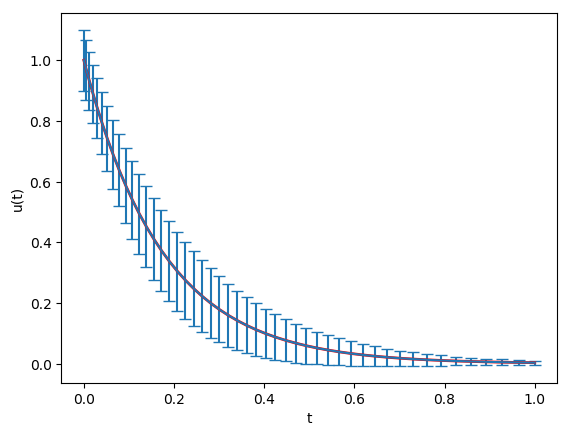

In [57]:
# analytic solution
u = u0 .* exp.(-c .* sol.t);

# plot solution
ts = getfield.(sol.t, :val)
solvals = getfield.(sol, :val)
solerrs = getfield.(sol, :err);

errorbar(ts, solvals, yerr=solerrs)
plot(ts, getfield.(u, :val), color="red", lw=2)
ylabel("u(t)")
xlabel("t");

Note that, in some sense, **Julia implemented that feature by itself**.

The authors of Measurements.jl and DifferentialEquations.jl never had any collabration on this.

It **just works**.

# Core messages of this Notebook

* It is simple to write **type-generic code** in Julia and you should do it.
* Generally, **generic code is just as fast as specific code**.
* Generic Programming + Multiple Dispatch + JIT = **lots of code sharing and emergent features**